In [1]:
from dataclasses import dataclass
from typing import Callable

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

from plotting import label_axes
from utils import gauss_cgs

# Magnetic field

Uniform $B_0$ field in X direction with Alfven-wave perturbation with small amplitude $\delta B << B_0$

TODO: $\delta B$ must be a spectrum not a monochromatic wave!


In [58]:
B0 = 1e-6 * gauss_cgs
deltaB = 1e-2 * B0

# plasma density
n_IMP = 1 / u.cm**3
rho_IMP = n_IMP * const.m_p
v_A = (B0 / np.sqrt(rho_IMP)).to(u.km / u.s)
print(f"v_A = {v_A:.2f} ({(v_A / const.c).decompose():.2e} * speed of light)")


@dataclass
class Particle:
    E: u.Quantity[u.eV]
    theta: float

    gamma: float
    v: u.Quantity[u.km / u.s]

    R_L: u.Quantity[u.au]
    Omega_L: u.Quantity[1 / u.day]
    T_L: u.Quantity[u.day]

    k_res: u.Quantity[1 / u.au]
    w_res: u.Quantity[1 / u.kyr]
    lambda_res: u.Quantity[u.au]

    def __str__(self) -> str:
        return "\n".join(
            [
                f"proton with E = {self.E:.2f} pitch angle = {180 * self.theta / np.pi}",
                f"v = {self.v / const.c:.2e} c; gamma = {self.gamma:.2e}",
                f"gyration params: R = {self.R_L:.2f} T = {self.T_L:.2f}",
                f"resonance conditions: k = {self.k_res:.2e}; wavelength = {self.lambda_res:.2f}",
            ]
        )

    @classmethod
    def from_energy_pitch_angle(cls, E: u.Quantity[u.eV], theta: float):
        gamma = (E / (const.m_p * const.c**2)).decompose()
        v = const.c * np.sqrt(1 - gamma ** (-2))
        R_L = (
            (gamma * const.m_p * v * np.sin(theta)) * const.c / (const.e.gauss * B0)
        ).to(u.au)
        k_res = (np.tan(theta) / R_L).to(1 / u.au)
        Omega_L = v * np.sin(theta) / R_L

        return Particle(
            E=E,
            theta=theta,
            gamma=gamma,
            v=v,
            R_L=R_L,
            Omega_L=Omega_L,
            T_L=(2 * np.pi / Omega_L).to(u.day),
            k_res=k_res,
            w_res=(k_res * v_A).to(1 / u.kyr),
            lambda_res=1 / k_res,
        )


print(Particle.from_energy_pitch_angle(E=1 * u.TeV, theta=np.pi / 4))

v_A = 7.73 km / s (2.58e-05 * speed of light)
proton with E = 1.00 TeV pitch angle = 45.0
v = 1.00e+00 c; gamma = 1.07e+03
gyration params: R = 157.67 AU T = 8.09 d
resonance conditions: k = 6.34e-03 1 / AU; wavelength = 157.67 AU


In [59]:
def B_field(
    x: u.Quantity[u.au],
    y: u.Quantity[u.au],
    z: u.Quantity[u.au],
    t: u.Quantity[u.kyr],
    k: u.Quantity[1 / u.au],
    phase: float = 0.0,
) -> tuple[u.Quantity[gauss_cgs], ...]:
    assert x.shape == y.shape == z.shape
    B_x = B0 * np.ones_like(x).value
    w = (k * v_A).to(1 / u.kyr)
    B_y = deltaB * np.cos((k * x - w * t).decompose().value + phase)
    B_z = deltaB * np.sin((k * x - w * t).decompose().value + phase)
    return B_x, B_y, B_z

# Full numerical integration to obtain particle trajectory

To pass the problem to the ODE solver, we need to rewrite it in standard form
$\frac{d \vec{\theta}}{dt} = f(t, \vec{\theta})$ with initial condition
$\vec \theta(t_0) = \vec \theta_0$. For our problem we can use

$$
\theta = \begin{pmatrix}
v_x \\
v_y \\
v_z \\
x \\
y \\
z \\
\end{pmatrix}
$$

Then,

$$
f = \begin{pmatrix}
\frac{q}{c m \gamma} (v_y B_z - v_z B_y) \\
\frac{q}{c m \gamma} (-v_x B_z + v_z B_x) \\
\frac{q}{c m \gamma} (v_x B_y - v_y B_x) \\
v_x \\
v_y \\
v_z \\
\end{pmatrix}


$$


In [94]:
from typing import Literal
from tqdm import tqdm


L_UNIT = u.au
T_UNIT = u.day
V_UNIT = L_UNIT / T_UNIT
A_UNIT = L_UNIT / (T_UNIT**2)
Approx = Literal["no-wave", "qlt", "full"]
APPROX_OPTS: list[Approx] = ["no-wave", "qlt", "full"]


def get_ode_rhs(k: u.Quantity[1 / u.au], B_phase: float, gamma: float, approx: Approx):
    lorentz_force_norm = const.e.gauss / (const.c * const.m_p * gamma)
    v = (const.c * np.sqrt(1 - gamma ** (-2))).to(u.au / u.d)
    print(v)

    def f(
        t: float, params: np.ndarray, pbar: tqdm | None = None, verbose: bool = False
    ) -> np.ndarray:
        if pbar is not None:
            pbar.update()
        if verbose:
            print()
            print("t =", t)
            print("params =", params)
        if not np.all(np.isfinite(params)):
            raise ValueError(f"got NaN params: {params}")

        vx, vy, vz, x, y, z = params
        vx = vx * V_UNIT
        vy = vy * V_UNIT
        vz = vz * V_UNIT

        v_abs = np.sqrt(vx**2 + vy**2 + vz**2)
        renorm_factor = (v / v_abs).decompose().value
        if verbose:
            print("v = ", v_abs, "renormalization = ", renorm_factor)
        # vx *= renorm_factor
        # vy *= renorm_factor
        # vz *= renorm_factor

        x = x * L_UNIT
        y = y * L_UNIT
        z = z * L_UNIT
        t = t * T_UNIT

        Bx, By, Bz = B_field(x, y, z, t, k, phase=B_phase)
        if verbose:
            print(f"B = [{Bx}, {By}, {Bz}]")

        perturb_x = False if approx == "no-wave" else True
        perturb_trans = True if approx == "full" else False

        # TEMP
        # print((lorentz_force_norm * (vy * Bz - vz * By)).to(A_UNIT))

        result = np.array(
            [
                (
                    (lorentz_force_norm * (vy * Bz - vz * By)).to(A_UNIT).value
                    if perturb_x
                    else 0
                ),
                (lorentz_force_norm * (vz * Bx - (vx * Bz if perturb_trans else 0)))
                .to(A_UNIT)
                .value,
                (lorentz_force_norm * (-vy * Bx + (vx * By if perturb_trans else 0)))
                .to(A_UNIT)
                .value,
                vx.value,
                vy.value,
                vz.value,
            ]
        )
        if verbose:
            print("result:", result)
        if not np.all(np.isfinite(result)):
            raise RuntimeError(f"Non-finite values in RHS: {result}")
        return result

    return f


def get_ode_initial(E: u.Quantity[u.eV], theta: float) -> np.ndarray:
    gamma = (E / (const.m_p * const.c**2)).decompose()
    v = const.c * np.sqrt(1 - gamma ** (-2))
    vx = v * np.cos(theta)
    v_trans = v * np.sin(theta)
    phi = 0
    # phi = np.random.random() * np.pi * 2
    return np.array(
        [
            vx.to(V_UNIT).value,
            (v_trans * np.cos(phi)).to(V_UNIT).value,
            (v_trans * np.sin(phi)).to(V_UNIT).value,
            0,
            0,
            0,
        ]
    )

### Unperturbed field solution (sanity check)

Should be a basic Larmor rotation...

423eval [00:00, 1497.79eval/s]

173.13701107356871 AU / d

t = 0.0
params = [ 86.56850554 149.94104993   0.           0.           0.
   0.        ]
v =  173.13701107356871 AU / d renormalization =  1.0
B = [1e-06 gauss_cgs, 5.000000000000001e-09 gauss_cgs, 8.660254037844386e-09 gauss_cgs]
result: [    0.             0.         -1164.32894988    86.56850554
   149.94104993     0.        ]

t = 1.2013957667264606e-08
params = [ 8.65685055e+01  1.49941050e+02 -1.39881987e-05  1.04003036e-06
  1.80138543e-06  0.00000000e+00]
v =  173.13701107356928 AU / d renormalization =  0.9999999999999967
B = [1e-06 gauss_cgs, 4.999999030538129e-09 gauss_cgs, 8.660254597563387e-09 gauss_cgs]
result: [ 0.00000000e+00 -1.08621787e-04 -1.16432895e+03  8.65685055e+01
  1.49941050e+02 -1.39881987e-05]

t = 2.402791533452921e-07
params = [ 8.65685055e+01  1.49941050e+02 -2.79763974e-04  2.08006072e-05
  3.60277085e-05  0.00000000e+00]
v =  173.13701107379475 AU / d renormalization =  0.9999999999986945
B = [1e-06 gauss_cgs, 4.999980610750

764eval [00:00, 1623.49eval/s]


t = 7.470824259106262
params = [  86.56850554   13.5462846  -152.60602494  646.73809124   19.65244238
  -17.56477353]
v =  175.9721762807865 AU / d renormalization =  0.9838885597306366
B = [1e-06 gauss_cgs, 2.6890493892820606e-10 gauss_cgs, 9.996383852864996e-09 gauss_cgs]
result: [    0.         -1185.0231331   -105.19021528    86.56850554
    13.5462846   -152.60602494]

t = 7.484136479896032
params = [  86.56850554   -3.38437244 -150.16837328  647.8905103    19.33852418
  -19.74508562]
v =  173.3669532006824 AU / d renormalization =  0.9986736680614817
B = [1e-06 gauss_cgs, -9.699431535353958e-10 gauss_cgs, 9.952849354778249e-09 gauss_cgs]
result: [    0.         -1166.09417139    26.2804803     86.56850554
    -3.38437244  -150.16837328]

t = 7.550697583844878
params = [  86.56850554  -64.95697929 -122.66044348  653.65260559   15.7960821
  -27.67434077]
v =  163.5820885818283 AU / d renormalization =  1.0584105666737516
B = [1e-06 gauss_cgs, -6.573908033595915e-09 gauss_cgs, 7.53

1281eval [00:00, 1686.66eval/s]


t = 17.61868634551763
params = [  86.56850554   21.96691156  137.79401901 1525.22334645  -17.74496794
  -16.4803741 ]
v =  164.2067082324582 AU / d renormalization =  1.0543845189836483
B = [1e-06 gauss_cgs, -2.7751635378621577e-09 gauss_cgs, 9.607209133672504e-09 gauss_cgs]
result: [   0.         1070.00428189 -170.57844452   86.56850554   21.96691156
  137.79401901]

t = 17.630344599055213
params = [  86.56850554   19.5505606   112.6621699  1526.23258404  -14.50851501
  -16.79154922]
v =  143.41929820353556 AU / d renormalization =  1.2072086061100287
B = [1e-06 gauss_cgs, -3.8003799825275695e-09 gauss_cgs, 9.249708751544762e-09 gauss_cgs]
result: [   0.          874.8493227  -151.81488792   86.56850554   19.5505606
  112.6621699 ]

t = 17.64491741597719
params = [  86.56850554   40.69640769  106.64056242 1527.49413102  -13.73305877
  -14.06840941]
v =  143.25680892647523 AU / d renormalization =  1.2085778845069006
B = [1e-06 gauss_cgs, -5.017530072608123e-09 gauss_cgs, 8.650109361

1783eval [00:01, 1639.01eval/s]


t = 27.474523509892663
params = [ 8.65685055e+01  1.47347486e+02  2.99700193e+01  2.37842844e+03
 -3.85950737e+00 -3.33996388e-01]
v =  173.5038613544794 AU / d renormalization =  0.9978856362155469
B = [1e-06 gauss_cgs, 8.4676199027763e-09 gauss_cgs, -5.31971927662604e-09 gauss_cgs]
result: [    0.           232.72453482 -1144.18929301    86.56850554
   147.34748623    29.97001929]

t = 27.526485868163245
params = [ 8.65685055e+01  1.43720906e+02 -2.49492949e+01  2.38292674e+03
  3.21294379e+00 -8.01023573e-01]
v =  169.6239141229112 AU / d renormalization =  1.0207110947110434
B = [1e-06 gauss_cgs, 9.970560020710353e-09 gauss_cgs, -7.667678093219296e-10 gauss_cgs]
result: [    0.          -193.73738119 -1116.0280087     86.56850554
   143.72090584   -24.94929491]

t = 27.535723620744683
params = [ 8.65685055e+01  1.32627521e+02 -2.56478009e+01  2.38372644e+03
  3.30289666e+00 -2.22961797e+00]
v =  160.44305872637196 AU / d renormalization =  1.0791181148499898
B = [1e-06 gauss_cgs, 

2120eval [00:01, 1596.09eval/s]


t = 34.138947882037314
params = [  86.56850554   41.31001062 -147.80850678 2955.35769875   19.03462307
  -13.98939028]
v =  176.2043637524269 AU / d renormalization =  0.9825920731272699
B = [1e-06 gauss_cgs, 2.7238959917623424e-09 gauss_cgs, -9.621870432824433e-09 gauss_cgs]
result: [    0.         -1147.76923046  -320.78234282    86.56850554
    41.31001062  -147.80850678]

t = 34.152088761942395
params = [  86.56850554   24.44109754 -148.54073037 2956.49528508   19.12891805
  -16.16175105]
v =  173.65431748046703 AU / d renormalization =  0.9970210564620341
B = [1e-06 gauss_cgs, 3.878703475955155e-09 gauss_cgs, -9.217139433989995e-09 gauss_cgs]
result: [    0.         -1153.45512584  -189.79110425    86.56850554
    24.44109754  -148.54073037]

t = 34.21779316146777
params = [  86.56850554  -40.72857379 -133.57033818 2962.18321676   17.20104679
  -24.55423235]
v =  164.29838135526035 AU / d renormalization =  1.0537962069096511
B = [1e-06 gauss_cgs, 8.471195845410278e-09 gauss_cgs,

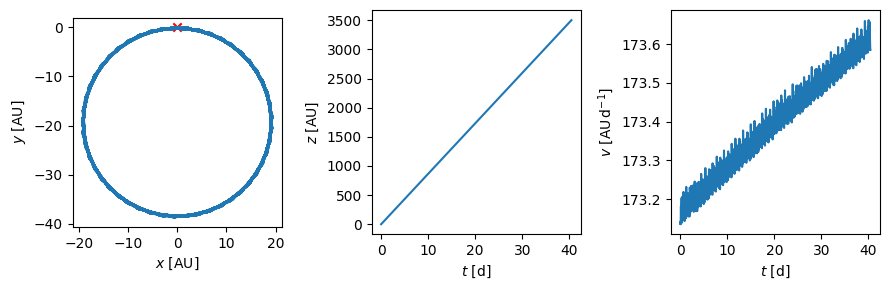

In [95]:
E = 100 * u.GeV
gamma = E / (const.m_p * const.c**2)
theta = np.pi / 3
particle = Particle.from_energy_pitch_angle(E=E, theta=theta)
theta0 = get_ode_initial(E, theta)

t_max = 50 * particle.T_L
t_eval = (
    np.arange(0, t_max.to(T_UNIT).value, particle.T_L.to(T_UNIT).value / 16.3415)
    * T_UNIT
)
with tqdm(unit="eval") as pbar:
    no_wave_solution = solve_ivp(
        fun=get_ode_rhs(
            k=particle.k_res * 1.2,
            B_phase=np.pi / 3,
            gamma=gamma,
            approx="no-wave",
        ),
        t_span=(0, t_max.to(T_UNIT).value),
        y0=theta0,
        args=[pbar, True],
        t_eval=t_eval,
        # max_step=(particle.T_L / 20).to(T_UNIT).value,
    )

_, axes = plt.subplots(ncols=3, figsize=(9, 3))
axes[0].plot(no_wave_solution.y[4, :] * L_UNIT, no_wave_solution.y[5, :] * L_UNIT)
axes[0].scatter(0, 0, marker="x", color="r")
axes[0].set_aspect(1)
label_axes(axes[0], "x", "y")
axes[1].plot(t_eval, no_wave_solution.y[3, :] * L_UNIT)
label_axes(axes[1], "t", "z")
axes[2].plot(t_eval, np.sqrt(np.sum(no_wave_solution.y[0:3, :] ** 2, axis=0)) * V_UNIT)
label_axes(axes[2], "t", "v")
plt.tight_layout()

### QLT solution

2120eval [00:00, 2285.62eval/s]


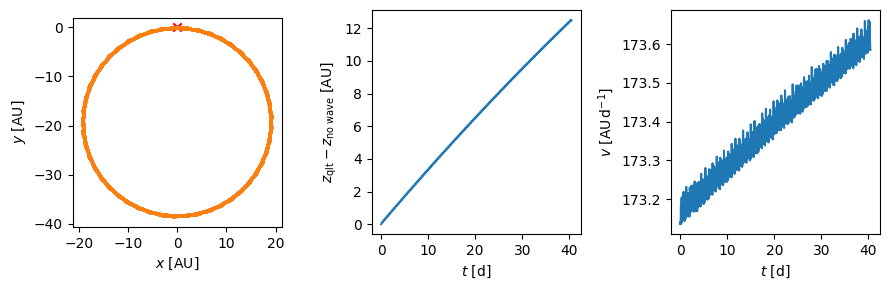

In [81]:
with tqdm(unit="eval") as pbar:
    qlt_solution = solve_ivp(
        fun=get_ode_rhs(
            k=particle.k_res * 1.2,
            B_phase=np.pi / 3,
            gamma=gamma,
            approx="qlt",
        ),
        t_span=(0, t_max.to(T_UNIT).value),
        y0=theta0,
        args=[pbar, False],
        t_eval=t_eval,
        # max_step=(particle.T_L / 20).to(T_UNIT).value,
    )

_, axes = plt.subplots(ncols=3, figsize=(9, 3))
axes[0].plot(qlt_solution.y[4, :] * L_UNIT, qlt_solution.y[5, :] * L_UNIT)
axes[0].plot(no_wave_solution.y[4, :] * L_UNIT, no_wave_solution.y[5, :] * L_UNIT)
axes[0].scatter(0, 0, marker="x", color="r")
axes[0].set_aspect(1)
label_axes(axes[0], "x", "y")
axes[1].plot(t_eval, (qlt_solution.y[3, :] - no_wave_solution.y[3, :]) * L_UNIT)
label_axes(axes[1], "t", "z_{\\text{qlt}} - z_{\\text{no wave}}")
axes[2].plot(t_eval, np.sqrt(np.sum(no_wave_solution.y[0:3, :] ** 2, axis=0)) * V_UNIT)
label_axes(axes[2], "t", "v")
plt.tight_layout()

# TBD

In [7]:
E = 1000 * u.GeV
gamma = E / (const.m_p * const.c**2)
theta = np.pi / 4
particle = Particle.from_energy_pitch_angle(E=E, theta=theta)

t_max = 100 * particle.T_L
print(f"integrating up to t = {t_max:.2f}")
t_eval = (
    np.arange(0, t_max.to(T_UNIT).value, particle.T_L.to(T_UNIT).value / 30) * T_UNIT
)

solutions: dict[Approx, np.ndarray] = dict()
theta0 = get_ode_initial(E, theta)
# for approx in ("full",):
for approx in APPROX_OPTS:
    with tqdm(unit="eval") as pbar:
        no_wave_solution = solve_ivp(
            fun=get_ode_rhs(
                k=particle.k_res,
                B_phase=np.pi / 3,
                gamma=gamma,
                approx=approx,
            ),
            t_span=(0, t_max.to(T_UNIT).value),
            y0=theta0,
            t_eval=t_eval.to(T_UNIT).value,
            method="RK45",
            args=[pbar, False],
            max_step=(particle.T_L / 100).to(T_UNIT).value,
        )
    solutions[approx] = no_wave_solution.y

integrating up to t = 809.14 d


60026eval [00:20, 2868.62eval/s]
60026eval [00:24, 2413.84eval/s]
60026eval [00:24, 2484.34eval/s]


In [8]:
def pitch_angle(solution: np.ndarray) -> np.ndarray:
    vx = solution[0, :]
    vy = solution[1, :]
    vz = solution[2, :]
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    mu = vx / v
    return (180 * np.arccos(mu) / np.pi) * u.deg


def period_average(
    t: u.Quantity[u.yr], value: u.Quantity, window: u.Quantity[u.yr]
) -> u.Quantity:
    t_step = t[1] - t[0]
    ma_steps_raw = (window / t_step).decompose()
    ma_steps = int(round(ma_steps_raw.value))
    ma = lambda arr: np.convolve(arr, np.ones(ma_steps) / ma_steps, "valid")
    return ma(t), ma(value)

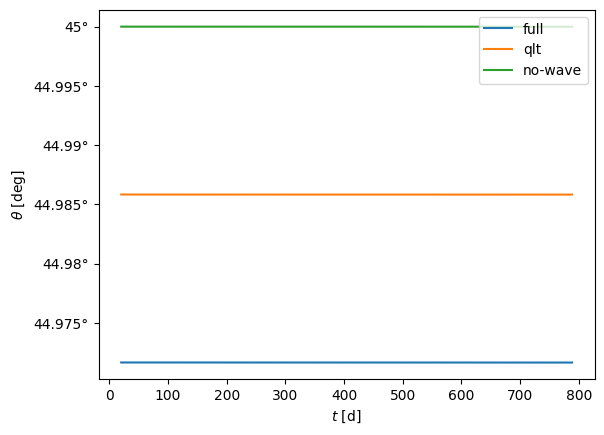

In [9]:
_, ax = plt.subplots()

for approx, no_wave_solution in list(reversed(solutions.items())):
    ax.plot(
        *period_average(t_eval, pitch_angle(no_wave_solution), window=5 * particle.T_L),
        label=approx,
    )

# ax.axhline(180 * theta / np.pi, color="k", linestyle="--")
label_axes(ax, "t", "\\theta")
ax.legend()
plt.show()

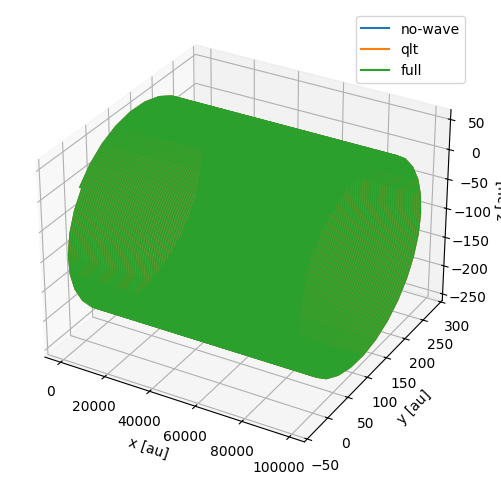

In [10]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

ax = plt.figure(figsize=(8, 6)).add_subplot(projection="3d")
ax: Axes3D

for approx, no_wave_solution in solutions.items():
    ax.plot(
        no_wave_solution[3, :],
        no_wave_solution[4, :],
        no_wave_solution[5, :],
        label=approx,
    )

ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")
ax.set_zlabel("z [au]")

ax.legend()
plt.show()

# Numerical integration of QLT equation for pitch angle

$$
\frac{d \mu}{dt} = \Omega \frac{\delta B}{B_0} \sqrt{1 - \mu^2} \cos((\Omega + \omega) t - k v \mu t)
$$

In [55]:
def get_mu_rhs(
    particle: Particle,
    k: u.Quantity[1 / u.pc] | Literal["resonant"],
    phase_diff: float,
    mu_0: float,
) -> tuple[Callable, float]:

    def mu_rhs(
        t: float, mu: np.ndarray, pbar: tqdm | None = None, verbose: bool = False
    ) -> np.ndarray:
        if pbar is not None:
            pbar.update()
        t = t * T_UNIT
        result = (
            particle.Omega_L
            * (deltaB / B0)
            * np.sqrt(1 - mu**2)
            * np.cos(
                # some initial phase difference between particle Larmor rotation and deltaB
                phase_diff
                + (
                    ((particle.Omega_L - k * particle.v * mu) * t)
                    .to(u.dimensionless_unscaled)
                    .value
                    # resonant condition = this term vanishes
                    if k != "resonant"
                    else 0
                )
            )
        ).to(1 / T_UNIT)
        if verbose:
            print(f"result: {result}")
        return result

    return (
        mu_rhs,
        (
            min(
                (
                    1e-2
                    * (2 * np.pi / np.abs(particle.Omega_L - k * particle.v * mu_0[0]))
                    .to(T_UNIT)
                    .value
                ),
                1e-2 * particle.T_L.to(T_UNIT).value,
            )
            if k != "resonant"
            else particle.T_L.to(T_UNIT).value
        ),
    )

In [50]:
theta0 = np.pi / 4
particle = Particle.from_energy_pitch_angle(E=100 * u.GeV, theta=theta0)
mu_0 = np.array([np.cos(theta0)])
T_L_ = (particle.T_L).to(T_UNIT).value

12014it [00:07, 1645.36it/s]
12014it [00:07, 1641.91it/s]
12014it [00:07, 1630.32it/s]
12014it [00:07, 1602.67it/s]
12014it [00:07, 1557.62it/s]
12014it [00:07, 1593.79it/s]


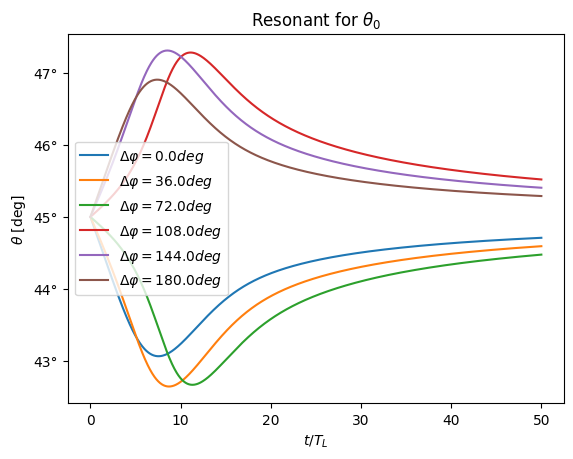

In [33]:
_, ax = plt.subplots()
for phase_diff in np.linspace(0, np.pi, 6):
    fun, step = get_mu_rhs(
        particle=particle,
        k=particle.k_res,
        phase_diff=phase_diff,
        mu_0=mu_0,
    )
    with tqdm() as pbar:
        no_wave_solution = solve_ivp(
            fun=fun,
            t_span=(0, 50 * T_L_),
            y0=mu_0,
            args=[pbar, False],
            max_step=step,
            method="DOP853",
        )
    ax.plot(
        (no_wave_solution.t * T_UNIT / particle.T_L).decompose(),
        180 * np.arccos(no_wave_solution.y[0, :]) / np.pi * u.deg,
        label=f"$\\Delta \\varphi = {{{180 * phase_diff / np.pi * u.deg:.1f}}}$",
    )
label_axes(ax, "t / T_L", "\\theta")
ax.legend()
ax.set_title("Resonant for $\\theta_0$")
plt.show()

308it [00:00, 3418.77it/s]
308it [00:00, 3488.83it/s]
308it [00:00, 2571.66it/s]
308it [00:00, 3586.11it/s]
308it [00:00, 3628.23it/s]
308it [00:00, 3531.14it/s]


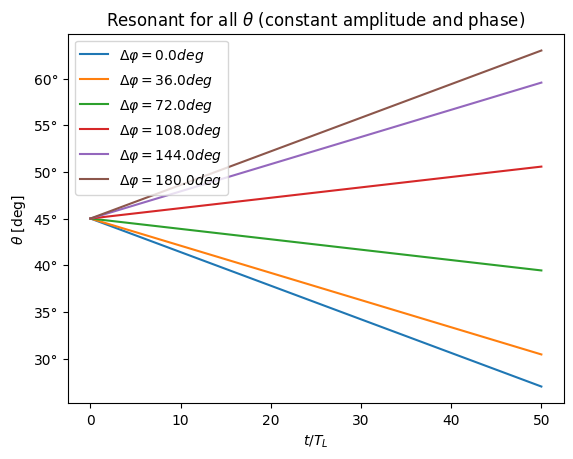

In [40]:
_, ax = plt.subplots()
for phase_diff in np.linspace(0, np.pi, 6):
    with tqdm() as pbar:
        fun, step = get_mu_rhs(particle=particle, k="resonant", phase_diff=phase_diff, mu_0=mu_0)
        no_wave_solution = solve_ivp(
            fun=fun,
            t_span=(0, 50 * T_L_),
            y0=mu_0,
            args=[pbar, False],
            max_step=step,
        )
    ax.plot(
        (no_wave_solution.t * T_UNIT / particle.T_L).decompose(),
        180 * np.arccos(no_wave_solution.y[0, :]) / np.pi * u.deg,
        label=f"$\\Delta \\varphi = {{{180 * phase_diff / np.pi * u.deg:.1f}}}$",
    )
label_axes(ax, "t / T_L", "\\theta")
ax.legend()
ax.set_title("Resonant for all $\\theta$ (constant amplitude and phase)")
plt.show()

60002it [00:05, 10260.05it/s]
60002it [00:05, 10472.47it/s]
60002it [00:05, 10217.15it/s]
60002it [00:05, 10231.31it/s]
60002it [00:05, 10371.20it/s]
60002it [00:05, 10453.01it/s]
60002it [00:05, 10504.04it/s]
60002it [00:05, 10458.02it/s]
240008it [00:24, 9661.44it/s] 
540002it [00:53, 10181.46it/s]
1140008it [01:53, 10040.73it/s]


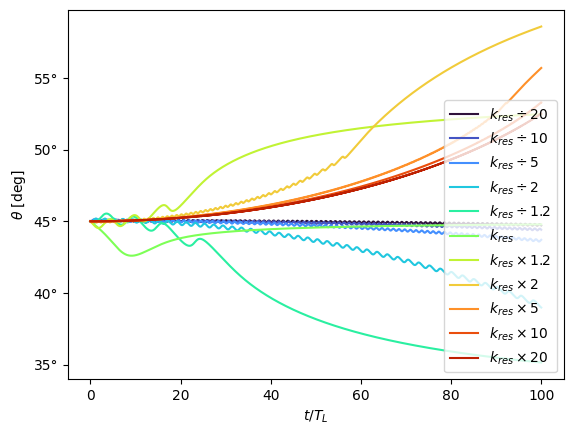

In [57]:
_, ax = plt.subplots()
multipliers = (1.2, 2, 5, 10, 20)
total = len(multipliers) * 2 + 1
cmap = matplotlib.colormaps["turbo"]
idx = 0
for power in (-1, 0, 1):
    for multiplier in sorted(multipliers, reverse=power < 0) if power != 0 else [1]:
        fun, step = get_mu_rhs(
            particle=particle,
            k=particle.k_res * multiplier**power,
            phase_diff=np.pi / 4,
            mu_0=mu_0,
        )
        with tqdm() as pbar:
            no_wave_solution = solve_ivp(
                fun=fun,
                t_span=(0, 100 * T_L_),
                y0=mu_0,
                args=[pbar, False],
                max_step=step,
            )
        ax.plot(
            (no_wave_solution.t * T_UNIT / particle.T_L).decompose(),
            180 * np.arccos(no_wave_solution.y[0, :]) / np.pi * u.deg,
            label=(
                f"$ k_{{res}} {'\\times' if power == 1 else '\\div'} {multiplier} $"
                if multiplier != 1
                else "$k_{res}$"
            ),
            color=cmap(idx / total),
        )
        idx += 1
label_axes(ax, "t / T_L", "\\theta")
ax.legend()
# ax.set_title("")
plt.show()